##### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import re
import time

In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


### Import data

In [3]:
train_file = "C:\\Users\\szuying.yang\\Downloads\\train (1).csv"
test_file = "C:\\Users\\szuying.yang\\Downloads\\test (1).csv"

In [4]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')

In [5]:
# Split data into training and validation
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

In [6]:
# Reshape the data to 4-dimensional
#The 2nd and 3rd dimension are the width and height of the image 
#4th dimension is the number of color channel, where gray for MNIST data is 1
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [7]:
# Trasfer the pixels from the scale of 0-255 to 0-1 in order to make the net converge faster
x_train = x_train.astype("float32")/255
x_val = x_val.astype("float32")/255

In [8]:
# set target to categorical factor - for multinomial classification
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print(y_train[0])

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


### Data Augmentation

In [15]:
# Keras function for real-time tensor image data augmentation
datagen = ImageDataGenerator(zoom_range = 0.1,
                            shear_range =0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10,
                            fill_mode='nearest')

### Train Convolutional Neural Network using Keras Sequential API

In [16]:
#Start to build a Sequential model, which is a linear stack of layers

model = Sequential()

In [17]:
# Stacking layers 
# Convolve with weight tensor, add bias, apply Rectifier as the activation function to pick up features 


# 16 3 by 3 filters that learn local features 
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
# Batch Normalization making training faster 
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())


#MaxPooling layer looks at four neighboring pixels and picks the maximal value. 
#It reduces the size of the image and learn more global features of the image 

model.add(MaxPool2D(strides=(2,2)))

# Dropout layer for regularization, which prevents overfitting by randomly dropping out connections or activations
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())


model.add(MaxPool2D(strides=(2,2)))

model.add(Dropout(0.25))

# Fully connected 
model.add(Flatten())


# Dense layer - fully connected layer with 512 hidden units
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# Output layer -softmax operation to normalize and force all probabilities sum up to one
model.add(Dense(10, activation='softmax'))

In [18]:
# specify how we want to train the model
# configure the learning process by assigning the loss function and the optimizer to pick the weights that minimize the loss function
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=["accuracy"])

In [19]:
# Starts training from a smaller learning rate to ensure convergence then speed up to reduce the learning rate by 10% every epoc
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [20]:
# Fit Model
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), #batch size specifies when to update the gradient
                           steps_per_epoch=500,
                           epochs=20, #how many times you go to the data that is grouped in mini-batch
                           verbose=2,  #2 for one log line per epoch
                           validation_data=(x_val[:400,:], y_val[:400,:]), #Use only part of the validation data for speed
                           callbacks=[annealer])

Epoch 1/20
25s - loss: 0.9304 - acc: 0.6974 - val_loss: 0.3285 - val_acc: 0.8975
Epoch 2/20
26s - loss: 0.3897 - acc: 0.8761 - val_loss: 0.1524 - val_acc: 0.9575
Epoch 3/20
27s - loss: 0.2880 - acc: 0.9108 - val_loss: 0.1033 - val_acc: 0.9675
Epoch 4/20
27s - loss: 0.2263 - acc: 0.9329 - val_loss: 0.0843 - val_acc: 0.9775
Epoch 5/20
30s - loss: 0.2067 - acc: 0.9370 - val_loss: 0.0717 - val_acc: 0.9825
Epoch 6/20
28s - loss: 0.1851 - acc: 0.9459 - val_loss: 0.0810 - val_acc: 0.9825
Epoch 7/20
28s - loss: 0.1782 - acc: 0.9482 - val_loss: 0.0700 - val_acc: 0.9800
Epoch 8/20
28s - loss: 0.1680 - acc: 0.9525 - val_loss: 0.0465 - val_acc: 0.9825
Epoch 9/20
28s - loss: 0.1378 - acc: 0.9604 - val_loss: 0.0634 - val_acc: 0.9875
Epoch 10/20
28s - loss: 0.1206 - acc: 0.9632 - val_loss: 0.0371 - val_acc: 0.9875
Epoch 11/20
30s - loss: 0.1204 - acc: 0.9664 - val_loss: 0.0588 - val_acc: 0.9825
Epoch 12/20
29s - loss: 0.1176 - acc: 0.9665 - val_loss: 0.0610 - val_acc: 0.9850
Epoch 13/20
30s - loss: 0

### Model Evaluation

In [21]:
# evaluate the model performance with the whole validation dataset
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0294, final accuracy: 0.9912


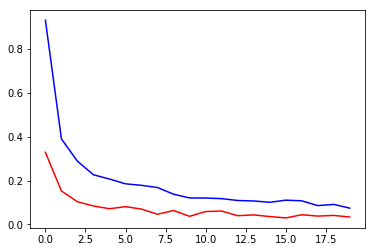

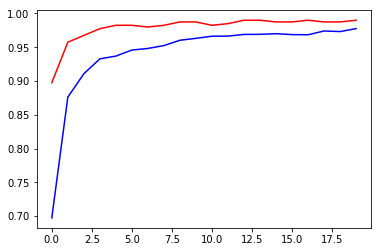

In [22]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [23]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[423   0   0   0   1   0   2   0   0   0]
 [  0 490   1   0   0   0   0   2   0   0]
 [  0   0 385   0   0   0   0   0   2   0]
 [  1   0   0 436   0   3   0   1   1   0]
 [  0   1   0   0 397   0   0   0   0   2]
 [  0   0   1   0   0 412   3   0   1   0]
 [  0   0   0   0   0   2 407   0   0   0]
 [  0   1   2   0   0   0   0 413   0   0]
 [  0   1   2   0   0   0   0   0 394   1]
 [  1   0   1   0   1   0   0   3   0 406]]


### Score test data

In [24]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.reshape(-1, 28, 28, 1)
x_test = x_test.astype("float32")/255

In [25]:
#Generate predictions for the test data by processing it batch by batch
y_hat = model.predict(x_test, batch_size=64)

In [26]:
y_pred = np.argmax(y_hat,axis=1)

### Create Submission

In [27]:
# create time stamp
time_stamp = re.sub('[: ]','_',time.asctime())
output_file = "C:\\Users\\szuying.yang\\Downloads\\submission_" +str(time_stamp) + ".csv"
# write 
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))